In [77]:
import numpy as np
import random

class GridWorld:
    # call to initialize grid world enviroment, default will be a 5x5 grid with a start point at the top left corner and goal at
    # the bottom right corner, no obsticals, if probablity of obsticals is given, these will be placed in enviroment randomly
    def __init__(self, grid_size=(5, 5), start_point=(0, 0), goal_point=None, prob_obstacle=0):
        self.grid_size = grid_size
        self.start_point = start_point
        self.goal_point = goal_point if goal_point is not None else (grid_size[0] - 1, grid_size[1] - 1)
        self.prob_obstacle = prob_obstacle

        self.action_map = ['up', 'down', 'left', 'right']
        self.grid = np.zeros(self.grid_size, dtype=int)
        self._generate_obstacles() 
        self.reset()

    def _generate_obstacles(self):
        self.grid = np.zeros(self.grid_size, dtype=int)
        for r in range(self.grid_size[0]):
            for c in range(self.grid_size[1]):
                if random.random() < self.prob_obstacle and (r, c) != self.start_point and (r, c) != self.goal_point:
                    self.grid[r, c] = 1

    def reset(self):
        self.agent_point = self.start_point

        return self.agent_point

    def step(self, action_idx):
        action = self.action_map[action_idx]
        x, y = self.agent_point
        next_x, next_y = x, y

        if action == 'up' and x > 0:
            next_x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            next_x += 1
        elif action == 'left' and y > 0:
            next_y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            next_y += 1

        # If next cell is an obstacle, stay in place and add penalty 
        if self.grid[next_x, next_y] == 1:
            reward = -5
            next_x, next_y = x, y

        self.agent_point = (next_x, next_y)
        done = self.is_at_goal()
        reward = 10 if done else -1
        return self.agent_point, reward, done, {}

    def is_at_goal(self):
        return self.agent_point == self.goal_point
    
    def display_env(self):
        world = np.array(self.grid, dtype=object)
        x, y = self.agent_point
        gx, gy = self.goal_point
        world[x, y] = 'A'  # Agent
        world[gx, gy] = 'G'  # Goal
        print(world)


In [78]:
class QLearningAgent:
    def __init__(self, grid_size, action_size=4, alpha=0.1, gamma=0, epsilon=0, epsilon_min=0.01, epsilon_decay=0):
        """
        Initialize the Q-learning agent.
        Args:
            grid_size: Size of the grid (grid_size x grid_size)
            action_size: Size of the action space (default 4: up, right, down, left)
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Decay rate for exploration
        """
        
        self.grid_size = grid_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table with zeros
        # Q-table shape: (grid_size, grid_size, action_size)

        self.q_table = np.zeros((grid_size[0], grid_size[1], action_size))

    def get_action(self, state, training=True):
        """
        Get action for the given state using epsilon-greedy policy.
        Args:
            state: Current state (x, y)
            training: Whether we're in training mode (use epsilon-greedy) or not
        Returns:
            action: Selected action
        """
        x, y = state
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # Exploration: choose a random action
        else:
            return np.argmax(self.q_table[x, y])        # Exploitation: choose the best action from Q-table

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-table using the Q-learning update rule.
        Args:
            state: Current state (x, y)
            action: Action taken
            reward: Reward received
            next_state: Next state (x, y)
            done: Whether the episode is done
        """
        x, y = state
        next_x, next_y = next_state
        
        # Q-learning update rule
        # Q(s,a) = Q(s,a) + alpha * [r + gamma * max(Q(s',a')) - Q(s,a)]
        
        if not done:
            target = reward + self.gamma * np.max(self.q_table[next_x, next_y])
        else:
            target = reward
            
        current = self.q_table[x, y, action]
        self.q_table[x, y, action] = current + self.alpha * (target - current)

    def decay_epsilon(self):
        """Decay exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [207]:
import os
import time

def train(env, agent, episodes=500, max_steps=100, log_interval=100):
    """
    Train the agent in the environment.
    Args:
        env: GridWorldEnv instance
        agent: QLearningAgent instance
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
    """

    rewards = []
    steps_list = []
    q_changes = []
    start_time = time.time()
    total_reward_accumulated = 0

    for episode in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0
        total_q_change = 0
        done = False

        for step in range(max_steps):
            action = agent.get_action(state)                         # Get action
            old_q = agent.q_table[state[0], state[1], action]        # Get info for old Q table
            next_state, reward, done, _ = env.step(action)           # Take step
            agent.update(state, action, reward, next_state, done)    # Update Q-table

            new_q = agent.q_table[state[0], state[1], action]        # Get info for new Q table
            total_q_change += abs(new_q - old_q)                     # Q-value delta

            # Update state and total reward
            state = next_state
            total_reward += reward

            if done:
                break

        # Decay exploration rate
        agent.decay_epsilon()
        
        # Save rewards, steps and q table change
        rewards.append(total_reward)
        total_reward_accumulated += total_reward
        steps_list.append(step + 1)
        q_changes.append(total_q_change)

        # Log progress
        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_steps = np.mean(steps_list[-log_interval:])
            avg_q_change = np.mean(q_changes[-log_interval:])
            print(f"Episode {episode}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | QΔ: {avg_q_change:.4f} | Epsilon: {agent.epsilon:.4f}")

    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")
    print(f"\nTotal Reward Accumulated: {total_reward_accumulated}.")
    return rewards, q_changes

In [208]:
def evaluate(env, agent, episodes=10, max_steps=100, render=True):
    rewards = []
    steps_list = []
    success_count = 0
    
    for ep in range(episodes):
        state, total_reward, done = env.reset(), 0, False
        path = [state]
        for step in range(max_steps):
            action = agent.get_action(state, training=False)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(state)
            total_reward += reward
            if done:
                if reward > 0: success_count += 1
                break

        rewards.append(total_reward)
        steps_list.append(step + 1)

        print(f"Episode {ep+1}/{episodes} | Reward: {total_reward} | Steps: {step + 1}")
    print(f"\nSuccess Rate: {success_count / episodes * 100:.2f}%")

    return rewards

In [217]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
    
def plot_convergence(rewards, q_changes):
    # Plot Average Reward per Episode
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(q_changes)
    plt.title(f'Average QΔ per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Q-value Change')



Set up 5x5 grid enviroment with obstacle probability and a basic agent with no enhancements 

[['A' 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 'G']]
Episode 10/100 | Avg Reward: -56.70 | Avg Steps: 65.50 | QΔ: 4.7788 | Epsilon: 0.0000
Episode 20/100 | Avg Reward: -39.80 | Avg Steps: 50.80 | QΔ: 1.7909 | Epsilon: 0.0000
Episode 30/100 | Avg Reward: -47.80 | Avg Steps: 57.70 | QΔ: 1.1435 | Epsilon: 0.0000
Episode 40/100 | Avg Reward: -45.70 | Avg Steps: 56.70 | QΔ: 0.6850 | Epsilon: 0.0000
Episode 50/100 | Avg Reward: -47.80 | Avg Steps: 58.80 | QΔ: 0.4369 | Epsilon: 0.0000
Episode 60/100 | Avg Reward: -46.50 | Avg Steps: 57.50 | QΔ: 0.2708 | Epsilon: 0.0000
Episode 70/100 | Avg Reward: -49.20 | Avg Steps: 59.10 | QΔ: 0.1763 | Epsilon: 0.0000
Episode 80/100 | Avg Reward: -45.50 | Avg Steps: 56.50 | QΔ: 0.1074 | Epsilon: 0.0000
Episode 90/100 | Avg Reward: -44.40 | Avg Steps: 54.30 | QΔ: 0.0681 | Epsilon: 0.0000
Episode 100/100 | Avg Reward: -48.70 | Avg Steps: 59.70 | QΔ: 0.0553 | Epsilon: 0.0000

Training completed in 0.29 seconds.

Total Reward Accumulated: -4721

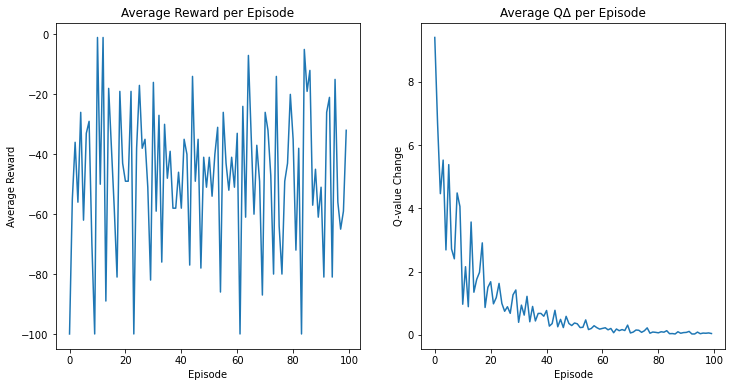

In [218]:
env = GridWorld(grid_size=(5,5), prob_obstacle=0.2)
agent = QLearningAgent(grid_size=(5,5))

env.display_env()
    
rewards, q_changes = train(env, agent, episodes=100, max_steps=100, log_interval=10)
plot_convergence(rewards, q_changes)

In [219]:
ev_reward = evaluate(env, agent, episodes=10)

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 0.00%


Gamma increase
set gamma to .5 so that future rewards weigh more than immediate rewards

Episode 10/100 | Avg Reward: -30.80 | Avg Steps: 40.70 | QΔ: 4.0938 | Epsilon: 0.0000
Episode 20/100 | Avg Reward: -17.00 | Avg Steps: 28.00 | QΔ: 2.1574 | Epsilon: 0.0000
Episode 30/100 | Avg Reward: -10.30 | Avg Steps: 21.30 | QΔ: 1.2947 | Epsilon: 0.0000
Episode 40/100 | Avg Reward: -7.80 | Avg Steps: 18.80 | QΔ: 0.8780 | Epsilon: 0.0000
Episode 50/100 | Avg Reward: -3.30 | Avg Steps: 14.30 | QΔ: 0.5512 | Epsilon: 0.0000
Episode 60/100 | Avg Reward: -2.80 | Avg Steps: 13.80 | QΔ: 0.4152 | Epsilon: 0.0000
Episode 70/100 | Avg Reward: -1.50 | Avg Steps: 12.50 | QΔ: 0.2860 | Epsilon: 0.0000
Episode 80/100 | Avg Reward: 0.50 | Avg Steps: 10.50 | QΔ: 0.1294 | Epsilon: 0.0000
Episode 90/100 | Avg Reward: 1.30 | Avg Steps: 9.70 | QΔ: 0.0807 | Epsilon: 0.0000
Episode 100/100 | Avg Reward: 0.70 | Avg Steps: 10.30 | QΔ: 0.1073 | Epsilon: 0.0000

Training completed in 0.08 seconds.

Total Reward Accumulated: -710.


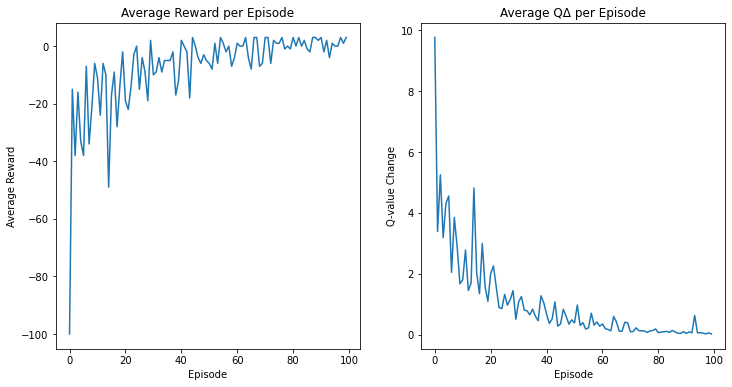

In [220]:
gamma_agent = QLearningAgent(grid_size=(5,5), gamma=.5)

rewards, q_changes = train(env, gamma_agent, episodes=100, max_steps=100, log_interval=10)
plot_convergence(rewards, q_changes)

In [221]:
r = evaluate(env, gamma_agent, episodes=10)

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 100.00%


Model is inconcistent, but now makes predictions. 

Now tune only learning rate hyperparameter alpha to see its effect.
Take half of the learning rate, .05

Episode 10/100 | Avg Reward: -56.70 | Avg Steps: 65.50 | QΔ: 2.8837 | Epsilon: 0.0000
Episode 20/100 | Avg Reward: -39.80 | Avg Steps: 50.80 | QΔ: 1.5016 | Epsilon: 0.0000
Episode 30/100 | Avg Reward: -47.80 | Avg Steps: 57.70 | QΔ: 1.1874 | Epsilon: 0.0000
Episode 40/100 | Avg Reward: -45.70 | Avg Steps: 56.70 | QΔ: 0.8723 | Epsilon: 0.0000
Episode 50/100 | Avg Reward: -47.80 | Avg Steps: 58.80 | QΔ: 0.6830 | Epsilon: 0.0000
Episode 60/100 | Avg Reward: -46.50 | Avg Steps: 57.50 | QΔ: 0.5123 | Epsilon: 0.0000
Episode 70/100 | Avg Reward: -49.20 | Avg Steps: 59.10 | QΔ: 0.4023 | Epsilon: 0.0000
Episode 80/100 | Avg Reward: -45.50 | Avg Steps: 56.50 | QΔ: 0.2999 | Epsilon: 0.0000
Episode 90/100 | Avg Reward: -44.40 | Avg Steps: 54.30 | QΔ: 0.2246 | Epsilon: 0.0000
Episode 100/100 | Avg Reward: -48.70 | Avg Steps: 59.70 | QΔ: 0.2067 | Epsilon: 0.0000

Training completed in 0.18 seconds.

Total Reward Accumulated: -4721.


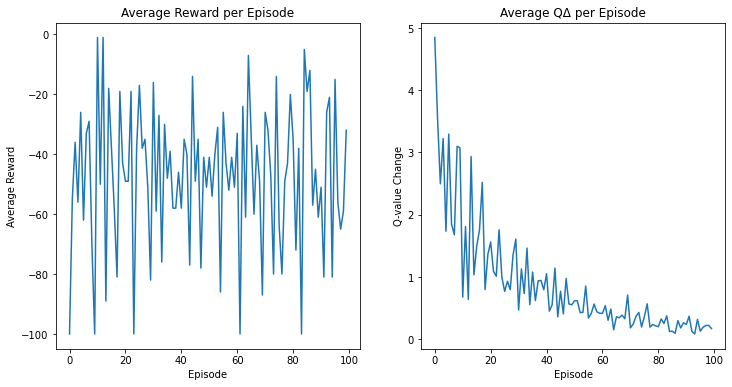

In [224]:
alpha_agent = QLearningAgent(grid_size=(5,5), alpha=.05)
    
rewards, q_changes = train(env, alpha_agent, episodes=100, max_steps=100, log_interval=10)
plot_convergence(rewards, q_changes)

In [225]:
r = evaluate(env, alpha_agent, episodes=10)

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 0.00%


Now tune with a higher learining rate

Episode 10/100 | Avg Reward: -56.70 | Avg Steps: 65.50 | QΔ: 7.0802 | Epsilon: 0.0000
Episode 20/100 | Avg Reward: -39.80 | Avg Steps: 50.80 | QΔ: 1.5005 | Epsilon: 0.0000
Episode 30/100 | Avg Reward: -47.80 | Avg Steps: 57.70 | QΔ: 0.6285 | Epsilon: 0.0000
Episode 40/100 | Avg Reward: -45.70 | Avg Steps: 56.70 | QΔ: 0.2540 | Epsilon: 0.0000
Episode 50/100 | Avg Reward: -47.80 | Avg Steps: 58.80 | QΔ: 0.1122 | Epsilon: 0.0000
Episode 60/100 | Avg Reward: -51.40 | Avg Steps: 61.30 | QΔ: 0.0500 | Epsilon: 0.0000
Episode 70/100 | Avg Reward: -100.00 | Avg Steps: 100.00 | QΔ: 0.0000 | Epsilon: 0.0000
Episode 80/100 | Avg Reward: -100.00 | Avg Steps: 100.00 | QΔ: 0.0000 | Epsilon: 0.0000
Episode 90/100 | Avg Reward: -100.00 | Avg Steps: 100.00 | QΔ: 0.0000 | Epsilon: 0.0000
Episode 100/100 | Avg Reward: -100.00 | Avg Steps: 100.00 | QΔ: 0.0000 | Epsilon: 0.0000

Training completed in 0.28 seconds.

Total Reward Accumulated: -6892.


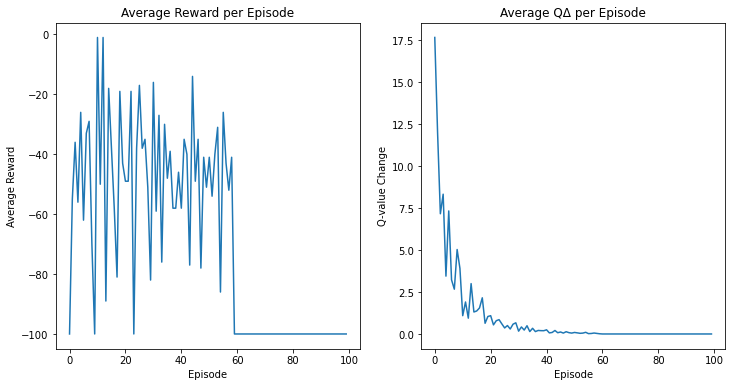

In [226]:
alpha_agent = QLearningAgent(grid_size=(5,5), alpha=.2)
    
rewards, q_changes = train(env, alpha_agent, episodes=100, max_steps=100, log_interval=10)
plot_convergence(rewards, q_changes)

In [228]:
r = evaluate(env, alpha_agent, episodes=10)

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 0.00%


lower learning rate has better results

Now we will tune epsilon, the default value is 0. so lets try an exploration approach by setting it to 1 and its decay to .9

Episode 10/100 | Avg Reward: -63.30 | Avg Steps: 69.90 | QΔ: 4.8578 | Epsilon: 0.9900
Episode 20/100 | Avg Reward: -57.60 | Avg Steps: 66.40 | QΔ: 2.0030 | Epsilon: 0.9802
Episode 30/100 | Avg Reward: -52.80 | Avg Steps: 62.70 | QΔ: 1.1466 | Epsilon: 0.9704
Episode 40/100 | Avg Reward: -40.50 | Avg Steps: 51.50 | QΔ: 0.7514 | Epsilon: 0.9608
Episode 50/100 | Avg Reward: -67.60 | Avg Steps: 74.20 | QΔ: 0.5429 | Epsilon: 0.9512
Episode 60/100 | Avg Reward: -80.30 | Avg Steps: 84.70 | QΔ: 0.3496 | Epsilon: 0.9417
Episode 70/100 | Avg Reward: -58.30 | Avg Steps: 67.10 | QΔ: 0.2016 | Epsilon: 0.9324
Episode 80/100 | Avg Reward: -64.30 | Avg Steps: 70.90 | QΔ: 0.1105 | Epsilon: 0.9231
Episode 90/100 | Avg Reward: -54.10 | Avg Steps: 64.00 | QΔ: 0.0859 | Epsilon: 0.9139
Episode 100/100 | Avg Reward: -58.20 | Avg Steps: 65.90 | QΔ: 0.0463 | Epsilon: 0.9048

Training completed in 0.21 seconds.

Total Reward Accumulated: -5970.


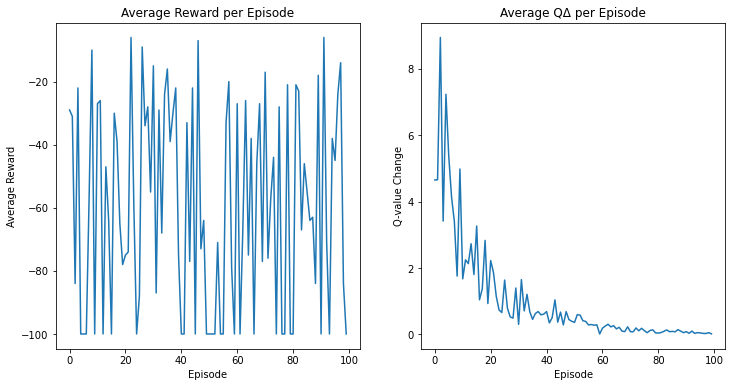

In [229]:
epsilon_agent = QLearningAgent(grid_size=(5,5), epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999)
    
rewards, q_changes = train(env, epsilon_agent, episodes=100, max_steps=100, log_interval=10)
plot_convergence(rewards, q_changes)

In [230]:
r = evaluate(env, epsilon_agent, episodes=10)

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 0.00%


Combine exploration with high discount factor

[[0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 'G']]
Episode 100/1000 | Avg Reward: -55.31 | Avg Steps: 63.67 | QΔ: 2.7066 | Epsilon: 0.9048
Episode 200/1000 | Avg Reward: -31.71 | Avg Steps: 41.83 | QΔ: 2.3817 | Epsilon: 0.8186
Episode 300/1000 | Avg Reward: -21.69 | Avg Steps: 32.47 | QΔ: 1.3153 | Epsilon: 0.7407
Episode 400/1000 | Avg Reward: -14.85 | Avg Steps: 25.85 | QΔ: 0.4997 | Epsilon: 0.6702
Episode 500/1000 | Avg Reward: -8.22 | Avg Steps: 19.22 | QΔ: 0.1299 | Epsilon: 0.6064
Episode 600/1000 | Avg Reward: -7.32 | Avg Steps: 18.32 | QΔ: 0.1096 | Epsilon: 0.5486
Episode 700/1000 | Avg Reward: -4.40 | Avg Steps: 15.40 | QΔ: 0.0396 | Epsilon: 0.4964
Episode 800/1000 | Avg Reward: -3.99 | Avg Steps: 14.99 | QΔ: 0.0157 | Epsilon: 0.4491
Episode 900/1000 | Avg Reward: -2.72 | Avg Steps: 13.72 | QΔ: 0.0335 | Epsilon: 0.4064
Episode 1000/1000 | Avg Reward: -1.47 | Avg Steps: 12.47 | QΔ: 0.0077 | Epsilon: 0.3677

Training completed in 0.91 seconds.

Total Reward Accumu

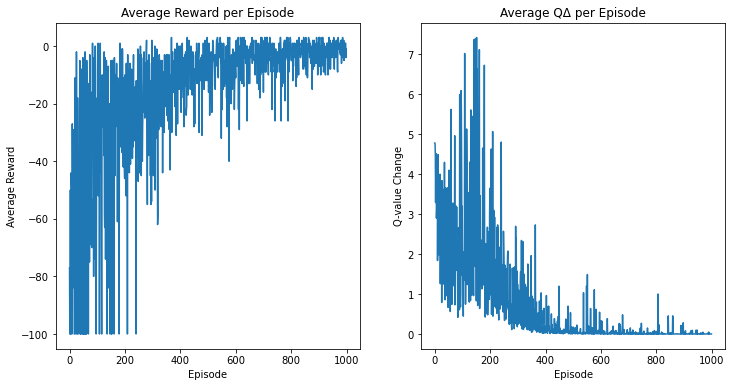

In [233]:
optimal_agent = QLearningAgent(grid_size=(5,5), alpha=.05, gamma=.99, epsilon=1.0, epsilon_min=0.001, epsilon_decay=0.999)
env.display_env()
rewards, q_changes = train(env, optimal_agent, episodes=1000, max_steps=100, log_interval=100)
plot_convergence(rewards, q_changes)

In [234]:
r = evaluate(env, optimal_agent, episodes=20)

Episode 1/20 | Reward: 3 | Steps: 8
Episode 2/20 | Reward: 3 | Steps: 8
Episode 3/20 | Reward: 3 | Steps: 8
Episode 4/20 | Reward: 3 | Steps: 8
Episode 5/20 | Reward: 3 | Steps: 8
Episode 6/20 | Reward: 3 | Steps: 8
Episode 7/20 | Reward: 3 | Steps: 8
Episode 8/20 | Reward: 3 | Steps: 8
Episode 9/20 | Reward: 3 | Steps: 8
Episode 10/20 | Reward: 3 | Steps: 8
Episode 11/20 | Reward: 3 | Steps: 8
Episode 12/20 | Reward: 3 | Steps: 8
Episode 13/20 | Reward: 3 | Steps: 8
Episode 14/20 | Reward: 3 | Steps: 8
Episode 15/20 | Reward: 3 | Steps: 8
Episode 16/20 | Reward: 3 | Steps: 8
Episode 17/20 | Reward: 3 | Steps: 8
Episode 18/20 | Reward: 3 | Steps: 8
Episode 19/20 | Reward: 3 | Steps: 8
Episode 20/20 | Reward: 3 | Steps: 8

Success Rate: 100.00%
